<a href="https://colab.research.google.com/github/midiazdi/ML/blob/master/Autoencoder_AnomaliasECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders para la detección de anomalías cardiacas

## 1- Implementación

### 1.1. lectura de los sets de entrenamiento y prueba

In [1]:
import pandas as pd
df_train = pd.read_csv('ECG5000_train.csv')
df_test = pd.read_csv('ECG5000_test.csv')

In [2]:
print(df_train.shape)
print(df_test.shape)

(6353, 141)
(1900, 141)


In [3]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1,-1.30300,-0.83573,-1.9336,-2.09420,-2.02840,-1.2531,-0.52638,-0.089286,-0.07557,...,-1.45820,-1.6676,-1.5977,-1.67930,-1.677200,-1.69370,-1.79410,-1.35940,-2.08120,-2.82880
1,2,0.32288,-0.87847,-1.8023,-2.66850,-3.26550,-3.3326,-2.88000,-2.227400,-1.54360,...,-1.23050,-1.7218,-2.1953,-2.74890,-3.446500,-3.66210,-3.01820,-1.65140,-0.23670,0.82832
2,2,1.39340,1.59260,1.2420,0.79449,0.19577,-0.3156,-0.58053,-0.945020,-1.23350,...,-1.90850,-2.5295,-3.0614,-3.50370,-3.900400,-4.24600,-4.13380,-3.19850,-2.42200,-1.07370
3,1,-3.52270,-5.02610,-4.3613,-4.10570,-3.10420,-1.8178,-1.39840,-1.070100,-0.40691,...,0.83038,1.0084,1.1830,0.94636,0.952130,0.79343,0.84741,1.01390,0.31234,-2.19060
4,1,-1.91820,-3.22510,-3.4652,-4.00800,-3.87030,-3.3581,-2.28540,-1.728500,-1.42220,...,1.77690,1.5029,1.1651,0.46073,0.019172,-0.32739,-0.48051,-0.18814,0.14284,-0.66844


In [4]:
df_train['0'].value_counts()

1    3718
2    2225
4     255
3     125
5      30
Name: 0, dtype: int64

### 1.2. Sets de entrenamiento y validación

In [5]:
# Pandas a arreglos numpy
datos_train = df_train.values
datos_test = df_test.values

# Etiquetas
cat_train = datos_train[:,0]
cat_test = datos_test[:,0]

# Subdivisión por categorías
x_train_1 = datos_train[cat_train==1,1:]
x_train_2 = datos_train[cat_train==2,1:]
x_train_3 = datos_train[cat_train==3,1:]
x_train_4 = datos_train[cat_train==4,1:]
x_train_5 = datos_train[cat_train==5,1:]

x_test_1 = datos_test[cat_test==1,1:]
x_test_2 = datos_test[cat_test==2,1:]
x_test_3 = datos_test[cat_test==3,1:]
x_test_4 = datos_test[cat_test==4,1:]
x_test_5 = datos_test[cat_test==5,1:]

<ipython-input-6-2ee3faeb3dde>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


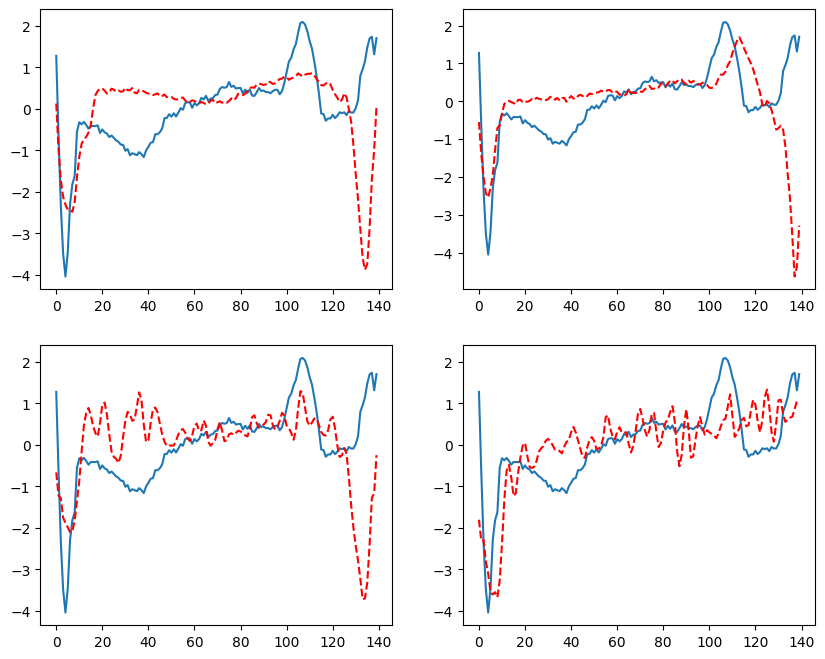

In [6]:
# Dibujar un dato normal y uno de cada anormal
import matplotlib.pyplot as plt
import numpy as np

ind = 10
normal = x_train_1[ind]
anormal_2 = x_train_2[ind]
anormal_3 = x_train_3[ind]
anormal_4 = x_train_4[ind]
anormal_5 = x_train_5[ind]

plt.figure(figsize=(10,8))
plt.grid()
plt.subplot(2,2,1)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_2, 'r--')
plt.subplot(2,2,2)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_3, 'r--')
plt.subplot(2,2,3)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_4, 'r--')
plt.subplot(2,2,4)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_5, 'r--')

### 1.3. Preprocesamiento (normalización)

In [7]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

x_train_1_s = min_max_scaler.fit_transform(x_train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(x_train_1), np.max(x_train_1)))
print('Mínimo y máximo normalización: {:.1f}, {:.1f}'.format(np.min(x_train_1_s), np.max(x_train_1_s)))

x_test_1_s = min_max_scaler.transform(x_test_1)
x_test_2_s = min_max_scaler.transform(x_test_2)
x_test_3_s = min_max_scaler.transform(x_test_3)
x_test_4_s = min_max_scaler.transform(x_test_4)
x_test_5_s = min_max_scaler.transform(x_test_5)

Mínimo y máximo originales: -7.1, 5.0
Mínimo y máximo normalización: 0.0, 1.0


### 1.4. Creación del Autoencoder en TensorFlow/Keras

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
np.random.seed(23)

dim_entrada = x_train_1_s.shape[1]    #140 muestras/ejemplo
entrada = Input(shape=(dim_entrada,))

# Encoder
encoder = Dense(32, activation='relu')(entrada)
encoder = Dense(16, activation='relu')(encoder)
encoder = Dense(8, activation='relu')(encoder)

# Decoder
decoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(140, activation='sigmoid')(decoder)

# Autoencoder = entrada + decoder (que ya contiene el encoder)
autoencoder = Model(inputs=entrada, outputs=decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 dense (Dense)               (None, 32)                4512      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 140)               4620  

### 1.5. Optimización y entrenamiento


In [9]:
autoencoder.compile(optimizer='adam', loss='mae')
historia = autoencoder.fit(x_train_1_s, x_train_1_s,
          epochs=20,
          batch_size=512,
          validation_data=(x_test_1_s, x_test_1_s),
          shuffle=True)

Epoch 1/20
8/8 [==============================] - 7s 33ms/step - loss: 0.1282 - val_loss: 0.1253
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1215 - val_loss: 0.1156
Epoch 3/20
8/8 [==============================] - 0s 10ms/step - loss: 0.1108 - val_loss: 0.1035
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0983 - val_loss: 0.0909
Epoch 5/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0861 - val_loss: 0.0798
Epoch 6/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0762 - val_loss: 0.0720
Epoch 7/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0700 - val_loss: 0.0679
Epoch 8/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0668 - val_loss: 0.0657
Epoch 9/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0648 - val_loss: 0.0641
Epoch 10/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0633 - val_loss: 0.0629
Epoch 11/20
8/8 [===================

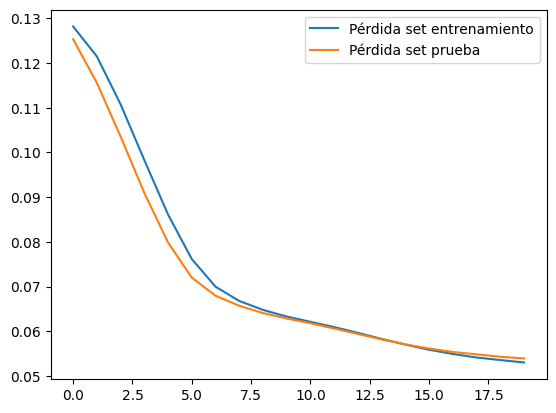

In [10]:
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["val_loss"], label="Pérdida set prueba")
plt.legend()

## 6- Clasificación

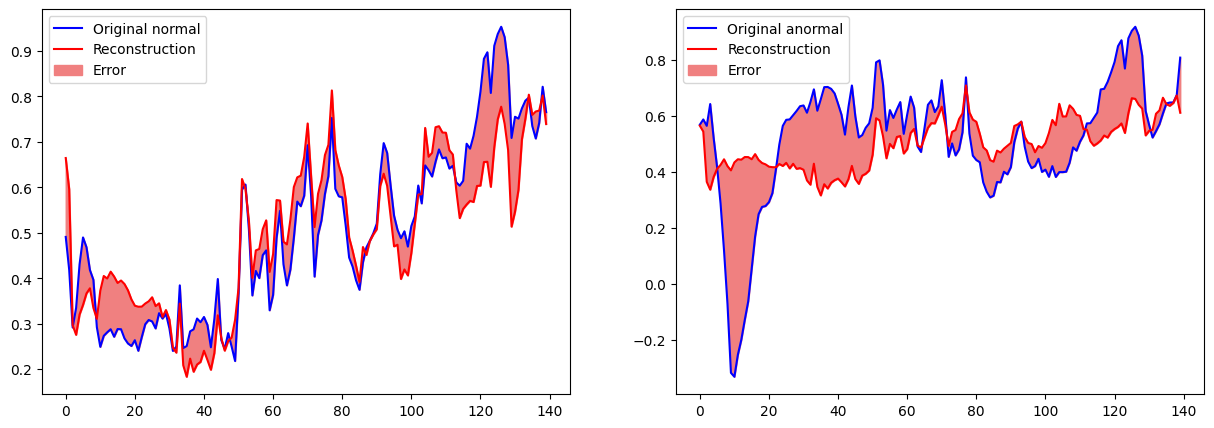

In [11]:
# ¿Qué tan bien reconstruye un dato "normal" y uno anormal?
rec_normal = autoencoder(x_test_1_s).numpy()
rec_anormal = autoencoder(x_test_5_s).numpy()

dato = 5
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x_test_1_s[dato],'b')
plt.plot(rec_normal[dato],'r')
plt.fill_between(np.arange(140), rec_normal[dato], x_test_1_s[dato], color='lightcoral')
plt.legend(labels=["Original normal", "Reconstruction", "Error"])
plt.subplot(1,2,2)
plt.plot(x_test_5_s[dato],'b')
plt.plot(rec_anormal[dato],'r')
plt.fill_between(np.arange(140), rec_anormal[dato], x_test_5_s[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

1/1 [==============================] - 0s 59ms/step


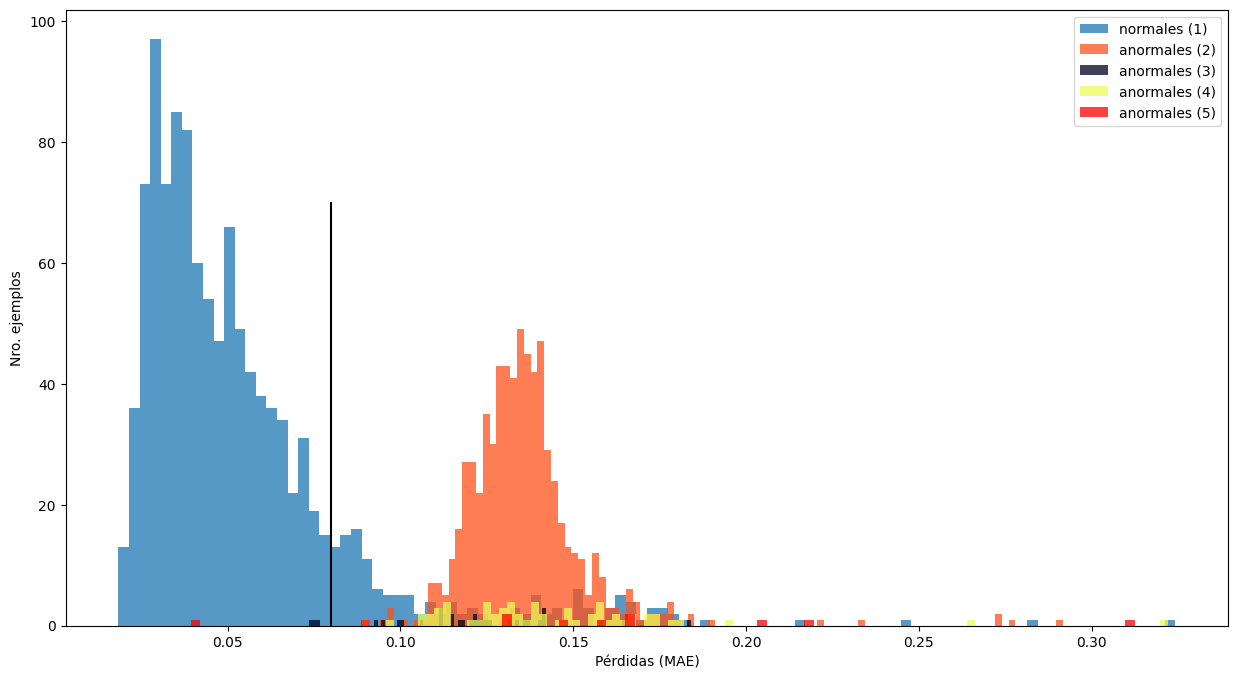

In [12]:
# Distribuciones de los errores de construcción
# para cada categoría

import tensorflow as tf

rec_1 = autoencoder.predict(x_test_1_s)
rec_2 = autoencoder.predict(x_test_2_s)
rec_3 = autoencoder.predict(x_test_3_s)
rec_4 = autoencoder.predict(x_test_4_s)
rec_5 = autoencoder.predict(x_test_5_s)

loss_1 = tf.keras.losses.mae(rec_1, x_test_1_s)
loss_2 = tf.keras.losses.mae(rec_2, x_test_2_s)
loss_3 = tf.keras.losses.mae(rec_3, x_test_3_s)
loss_4 = tf.keras.losses.mae(rec_4, x_test_4_s)
loss_5 = tf.keras.losses.mae(rec_5, x_test_5_s)


plt.figure(figsize=(15,8))
plt.hist(loss_1[None,:], bins=100, alpha=0.75, label='normales (1)')
plt.hist(loss_2[None,:], bins=100, alpha=0.75, color='#ff521b', label='anormales (2)')
plt.hist(loss_3[None,:], bins=100, alpha=0.75, color='#020122', label='anormales (3)')
plt.hist(loss_4[None,:], bins=100, alpha=0.75, color='#eefc57', label='anormales (4)')
plt.hist(loss_5[None,:], bins=100, alpha=0.75, color='r', label='anormales (5)')
plt.xlabel('Pérdidas (MAE)')
plt.ylabel('Nro. ejemplos')
plt.legend(loc='upper right')
plt.vlines(0.08,0,70,'k')



In [13]:
umbral = np.mean(loss_1) + np.std(loss_1)
print("Umbral: ", umbral)

Umbral:  0.08635124964216612


### 2.1. Sensitividad y especificidad



In [14]:
# Calcular predicciones individuales
def predecir(modelo, datos, umbral):
  reconstrucciones = modelo(datos)
  perdida = tf.keras.losses.mae(reconstrucciones, datos)
  return tf.math.less(perdida, umbral)

def calcular_sensitividad(prediccion, titulo):
  TP = np.count_nonzero(~prediccion)
  FN = np.count_nonzero(prediccion)
  sen = 100*(TP/(TP+FN))

  print(titulo + ': {:.1f}%'.format(sen))

def calcular_especificidad(prediccion, titulo):
  TN = np.count_nonzero(prediccion)
  FP = np.count_nonzero(~prediccion)
  esp = 100*(TN/(TN+FP))

  print(titulo + ': {:.1f}%'.format(esp))
  return esp

In [15]:
# Predicciones
pred_1 = predecir(autoencoder, x_test_1_s, umbral)
pred_2 = predecir(autoencoder, x_test_2_s, umbral)
pred_3 = predecir(autoencoder, x_test_3_s, umbral)
pred_4 = predecir(autoencoder, x_test_4_s, umbral)
pred_5 = predecir(autoencoder, x_test_5_s, umbral)

# Pred1: especificidad
esp_1 = calcular_especificidad(pred_1,'Especificidad (cat. 1, normales)')

# Pred 2 a 5: sensitividad
sen_2 = calcular_sensitividad(pred_2,'Sensitividad (cat. 2, anormales)')
sen_3 = calcular_sensitividad(pred_3,'Sensitividad (cat. 3, anormales)')
sen_4 = calcular_sensitividad(pred_4,'Sensitividad (cat. 4, anormales)')
sen_5 = calcular_sensitividad(pred_3,'Sensitividad (cat. 5, anormales)')

Especificidad (cat. 1, normales): 89.5%
Sensitividad (cat. 2, anormales): 100.0%
Sensitividad (cat. 3, anormales): 90.9%
Sensitividad (cat. 4, anormales): 100.0%
Sensitividad (cat. 5, anormales): 90.9%
